In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
!python -V

Python 3.7.6


In [8]:
!pip3 show tf-nightly

Name: tf-nightly
Version: 2.4.0.dev20200918
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/alexeyvaganov/opt/anaconda3/lib/python3.7/site-packages
Requires: absl-py, keras-preprocessing, typing-extensions, google-pasta, protobuf, grpcio, tb-nightly, termcolor, h5py, six, numpy, wheel, gast, wrapt, astunparse, opt-einsum, tf-estimator-nightly, flatbuffers
Required-by: 


In [ ]:
# pip install -q tf-nightly

https://www.tensorflow.org/tutorials/images/transfer_learning

# предварительная обработка

In [3]:
# укажите путь к папке с источников данных
# в истонике должно быть две папки: train,validation
# а в них уже папки с признаками

PATH = "D:\\GitHub\\PhotoForDota2"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1375 files belonging to 2 classes.
Found 360 files belonging to 2 classes.


Покажите первые девять изображений и меток из обучающего набора:

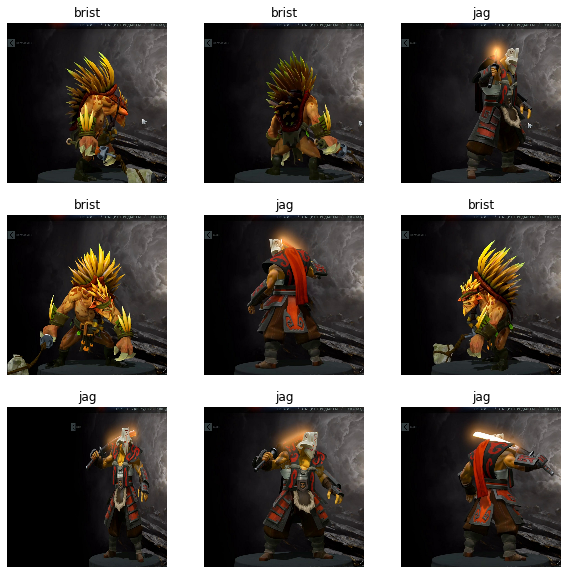

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Настройте набор данных для повышения производительности

Используйте буферизованную предварительную выборку для загрузки изображений с диска без блокировки ввода-вывода. Чтобы узнать больше об этом методе, см. Руководство по производительности данных .

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Используйте увеличение данных

Когда у вас нет большого набора данных изображения, рекомендуется искусственно вводить разнообразие образцов, применяя случайные, но реалистичные преобразования к обучающим изображениям, такие как поворот и горизонтальный поворот. Это помогает раскрыть модель различным аспектам обучающих данных и уменьшить переобучение . Вы можете узнать больше об увеличении данных в этом руководстве .

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Давайте несколько раз применим эти слои к одному и тому же изображению и посмотрим на результат.

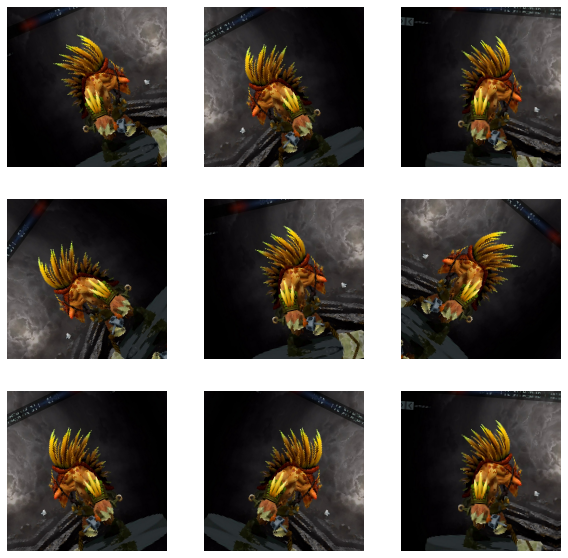

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Изменить масштаб значений пикселей 

Через мгновение вы загрузите tf.keras.applications.MobileNetV2 для использования в качестве базовой модели. Эта модель ожидает значений пикселей в [-1,1] , но на данный момент значения пикселей в ваших изображениях находятся в [0-255] . Чтобы изменить их масштаб, используйте метод предварительной обработки, включенный в модель.

Примечание. В качестве альтернативы вы можете изменить масштаб значений пикселей с [0,255] до [-1, 1] используя слой изменения масштаба .

Примечание. При использовании других tf.keras.applications обязательно проверьте документацию API, чтобы определить, ожидают ли они пикселей в [-1,1] или [0,1] , или используйте включенную функцию preprocess_input .

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# обучение последнего слоя

Создайте базовую модель из предварительно обученных сверток 

Вы создадите базовую модель на основе модели MobileNet V2, разработанной в Google. Это предварительно обучено на наборе данных ImageNet, большом наборе данных, состоящем из 1,4 млн изображений и 1000 классов. ImageNet - это набор данных для исследовательской подготовки с широким спектром категорий, таких как jackfruit и syringe . Эта база знаний поможет нам классифицировать кошек и собак по нашему конкретному набору данных.

Во-первых, вам нужно выбрать, какой уровень MobileNet V2 вы будете использовать для извлечения функций. Самый последний уровень классификации («сверху», поскольку большинство диаграмм моделей машинного обучения идут снизу вверх) не очень полезен. Вместо этого вы будете следовать общепринятой практике - полагаться на самый последний слой перед операцией выравнивания. Этот слой называется «узким местом». Элементы слоя «узкое место» сохраняют большую универсальность по сравнению с последним / верхним слоем.

Во-первых, создайте экземпляр модели MobileNet V2 с предварительно загруженными весами, обученными в ImageNet. Указав аргумент include_top = False , вы загружаете сеть, которая не включает слои классификации вверху, что идеально подходит для извлечения функций.

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 5s 1us/step


Эта функция экстрактор преобразует каждый 160x160x3 изображение в 5x5x1280 блок функций. Давайте посмотрим, что он делает с примером пакета изображений:

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Извлечение признаков

На этом шаге вы заморозите сверточную базу, созданную на предыдущем шаге, и будете использовать ее в качестве средства извлечения признаков. Кроме того, вы добавляете поверх него классификатор и обучаете классификатор верхнего уровня.

Заморозить сверточную базу

Перед компиляцией и обучением модели важно заморозить сверточную базу. Замораживание (путем установки layer.trainable = False) предотвращает обновление весов в данном слое во время обучения. MobileNet V2 имеет много уровней, поэтому установка флага trainable всей модели на False заморозит их все.

In [13]:
base_model.trainable = False

Важное примечание о слоях BatchNormalization

Многие модели содержат слои tf.keras.layers.BatchNormalization . Этот слой является особым случаем, и следует соблюдать меры предосторожности в контексте тонкой настройки, как показано далее в этом руководстве.

Когда вы устанавливаете layer.trainable = False , уровень BatchNormalization будет работать в режиме вывода и не будет обновлять свою статистику среднего значения и дисперсии.

Когда вы размораживаете модель, содержащую слои BatchNormalization, чтобы выполнить точную настройку, вы должны держать слои BatchNormalization в режиме вывода, передавая training = False при вызове базовой модели. В противном случае обновления, применяемые к необучаемым весам, уничтожат то, чему модель научилась.

Подробнее см. В руководстве по обучению передаче .

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Добавить заголовок классификации

Чтобы сгенерировать прогнозы из блока функций, tf.keras.layers.GlobalAveragePooling2D усреднение по пространственным местоположениям 5x5 , используя слой tf.keras.layers.GlobalAveragePooling2D для преобразования функций в один вектор из 1280 элементов для каждого изображения.

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Примените слой tf.keras.layers.Dense чтобы преобразовать эти функции в один прогноз для изображения. Здесь вам не нужна функция активации, потому что этот прогноз будет рассматриваться как logit или необработанное значение прогноза. Положительные числа предсказывают класс 1, отрицательные числа предсказывают класс 0.

In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Создайте модель, объединив вместе уровни увеличения, изменения масштаба, base_model и функции экстрактора данных с помощью функционального API Keras. Как упоминалось ранее, используйте training = False, поскольку наша модель содержит слой BatchNormalization.

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Скомпилируйте модель 

Скомпилируйте модель перед ее обучением. Поскольку существует два класса, используйте двоичную кросс-энтропийную потерю с from_logits=True поскольку модель обеспечивает линейный вывод.

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

Параметры 2,5Х в MobileNet заморожены, но есть 1.2K обучаемых параметров в плотном слое. Они разделены между двумя tf.Variable объектами, весами и смещениями.

In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

12/12 [==============================] - 7s 261ms/step - loss: 0.5857 - accuracy: 0.7972


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.56
initial accuracy: 0.82


Обучите модель 

После обучения в течение 10 эпох вы должны увидеть точность ~ 94% на проверочном наборе.

In [22]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
43/43 [==============================] - 26s 517ms/step - loss: 0.4206 - accuracy: 0.8400 - val_loss: 0.2985 - val_accuracy: 0.9028
Epoch 2/10
43/43 [==============================] - 19s 413ms/step - loss: 0.2343 - accuracy: 0.9316 - val_loss: 0.1969 - val_accuracy: 0.9944
Epoch 3/10
43/43 [==============================] - 19s 412ms/step - loss: 0.1514 - accuracy: 0.9796 - val_loss: 0.1423 - val_accuracy: 0.9972
Epoch 4/10
43/43 [==============================] - 20s 434ms/step - loss: 0.1025 - accuracy: 0.9905 - val_loss: 0.1099 - val_accuracy: 0.9972
Epoch 5/10
43/43 [==============================] - 21s 452ms/step - loss: 0.0786 - accuracy: 0.9949 - val_loss: 0.0888 - val_accuracy: 1.0000
Epoch 6/10
43/43 [==============================] - 21s 444ms/step - loss: 0.0625 - accuracy: 0.9949 - val_loss: 0.0740 - val_accuracy: 1.0000
Epoch 7/10
43/43 [==============================] - 21s 445ms/step - loss: 0.0475 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 1.0000

Кривые обучения 

Давайте посмотрим на кривые обучения точности / потери обучения и проверки при использовании базовой модели MobileNet V2 в качестве экстрактора фиксированных функций.

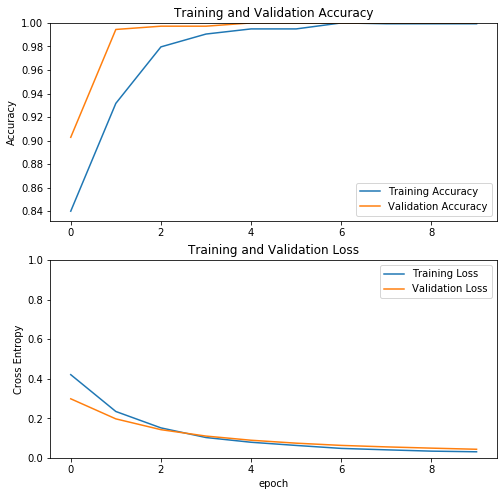

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# тонкая настройка

Тонкая настройка

В эксперименте по извлечению признаков вы тренировали только несколько слоев поверх базовой модели MobileNet V2. Веса предварительно обученной сети не обновлялись во время обучения.

Один из способов еще больше повысить производительность - это обучить (или «точно настроить») веса верхних слоев предварительно обученной модели вместе с обучением добавленного вами классификатора. Процесс обучения заставит настраивать веса с общих карт объектов на объекты, связанные специально с набором данных.

Примечание: это следует предпринимать только после того, как вы обучили классификатор верхнего уровня с предварительно обученной моделью, установленной на необучаемую. Если вы добавите случайно инициализированный классификатор поверх предварительно обученной модели и попытаетесь обучить все слои вместе, величина обновлений градиента будет слишком большой (из-за случайных весов классификатора), и ваша предварительно обученная модель будет забыть то, что он узнал.
Кроме того, вам следует попытаться настроить небольшое количество верхних уровней, а не всю модель MobileNet. В большинстве сверточных сетей, чем выше уровень, тем он более специализирован. Первые несколько слоев изучают очень простые и общие функции, которые распространяются практически на все типы изображений. По мере того, как вы поднимаетесь выше, функции становятся все более специфичными для набора данных, на котором была обучена модель. Цель точной настройки - адаптировать эти специализированные функции для работы с новым набором данных, а не перезаписывать общее обучение.

Разморозить верхние слои модели 

Все, что вам нужно сделать, это разморозить base_model и сделать нижние слои base_model . Затем вам следует перекомпилировать модель (необходимо, чтобы эти изменения вступили в силу) и возобновить обучение.

In [47]:
base_model.trainable = True

In [48]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


Скомпилируйте модель

Поскольку вы тренируете гораздо большую модель и хотите повторно адаптировать предварительно обученные веса, на этом этапе важно использовать более низкую скорость обучения. В противном случае ваша модель может очень быстро переобучиться.

In [49]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [51]:
len(model.trainable_variables)

56

Продолжить обучение модели 

Если вы раньше тренировались в конвергенции, этот шаг повысит вашу точность на несколько процентов.

In [53]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
25/63 [==========>...................] - ETA: 26s - loss: 0.0379 - accuracy: 0.9850

KeyboardInterrupt: 

Давайте посмотрим на кривые обучения точности / потери обучения и проверки при тонкой настройке последних нескольких уровней базовой модели MobileNet V2 и обучении классификатора поверх нее. Потеря проверки намного выше, чем потеря тренировки, поэтому вы можете получить некоторую переобучение.

Вы также можете столкнуться с переобучением, поскольку новый обучающий набор относительно невелик и похож на исходные наборы данных MobileNet V2.

После точной настройки модель почти достигает 98% точности на проверочном наборе.

In [54]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

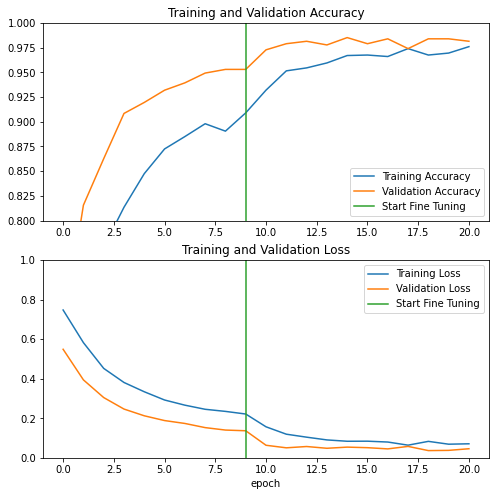

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Предсказание

In [30]:
image = tf.keras.preprocessing.image.load_img("D:\\Картинки1\\Jag.jpg",grayscale=False, color_mode="rgb", target_size=IMG_SIZE)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions_ = model.predict(input_arr)

predictions = tf.nn.sigmoid(predictions_)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy()[0][0])
print(class_names[predictions.numpy()[0][0]])
print(predictions_)

Predictions:
 1
jag
[[0.9478644]]


В меньшей степени это также связано с тем, что показатели обучения представляют собой среднее значение за эпоху, тогда как показатели проверки оцениваются после эпохи, поэтому показатели проверки видят модель, которая обучалась немного дольше.

In [41]:
predictions

array([[-3.1698468]], dtype=float32)

Наконец, вы можете проверить работоспособность модели на новых данных с помощью набора тестов.

In [31]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

NameError: name 'test_dataset' is not defined

# Сохранение модели

In [32]:
# Сохраним всю модель в  HDF5 файл
model.save('MobileNetV2_dota2.h5')